In [1]:
using OrdinaryDiffEq, LinearAlgebra
using QuantumToolbox
using PlotlyJS
using BenchmarkTools

We will simulate the density matrix by looking at the state's wigner function, comparing the full evolution to our model. First, the full evolution using QuantumToolbox.

Start off simple (just a qubit) with dissipation and then add on pieces one by one. Pieces to add are the initial diagonalization step, more levels, off-resonance, etc.

# Full numerical simulation

In [12]:
# set the parameters
N = 2
ωq = 1.0
ωd = 1.
εd = 0.15
κ = 1e-2*0

b = destroy(N)

Hq = ωq * b' * b
drive_operator = b' + b

function drive_coefficient(p, t)
    return p.εd * cos(p.ωd * t)
end

op = (Hq, (drive_operator, (p, t) -> p.εd * cos(p.ωd * t)));

# make collapse operators
c_ops = [√(κ) * b];

# set the initial state
ρ0 = ket2dm(basis(N, 0))

# set the time span
tspan = 0.0:0.1:8π / εd;


In [3]:
# solve the master equation using mesolve
sol = mesolve(op, ρ0, tspan, c_ops, params=(εd=εd, ωd=ωd));

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)


In [4]:
# function to plot the wigner function
function plot_wigner(rho,xx,yy)
    layout = Layout(
        xaxis_title="Re(β)",
        yaxis_title="Im(β)",
        title="Wigner function",
        width=500,
        height=500
    )
    
    w = wigner(rho, xx, yy);
    vbound = maximum(abs.(w))

    custom_colorscale = [
        [0, "blue"],   # Negative values to blue
        [0.5, "white"],  # Zero values to white
        [1, "red"],     # Positive values to red
    ]

    heatmap_trace = heatmap(
        z=w,
        x=xx,
        y=yy,
        colorscale=custom_colorscale,
        showscale=true,
        zmin = -vbound,
        zmax = vbound
    )

    plot(heatmap_trace, layout)
end;

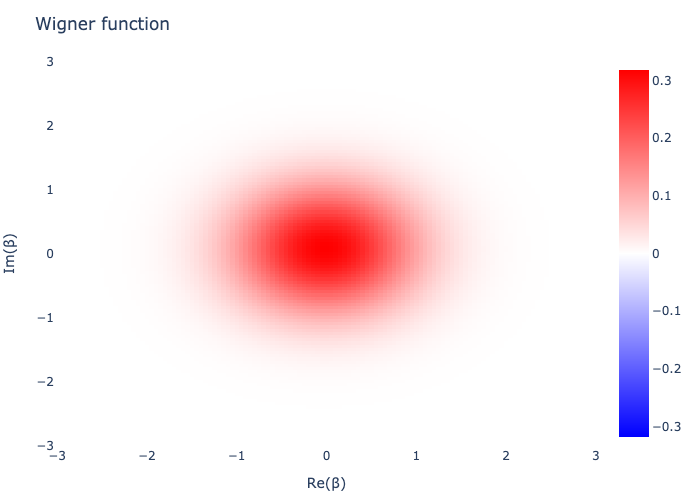

In [5]:
xvec = -3:0.05:3

plot_wigner(sol.states[end], xvec, xvec)

In [6]:
c00s = getindex.(sol.states, 1, 1);
c01s = getindex.(sol.states, 1, 2);
c10s = getindex.(sol.states, 2, 1);
c11s = getindex.(sol.states, 2, 2);

In [7]:
# make function to return coefficients in one line
function get_coefficient_mesolve(N, indices, u0, tspan, H0, O, ωd, εd, a, κ)
    op = (H0, (O, (p, t) -> p.εd * cos(p.ωd * t)));

    c_ops = [√(κ) * a];

    sol = mesolve(op, u0, tspan, c_ops, params=(εd=εd, ωd=ωd));

    cs = []
    for index in indices
        c = getindex.(sol.states, index...);
        push!(cs, c)
    end

    return tspan, cs
end

get_coefficient_mesolve (generic function with 1 method)

In [8]:
ts, cs = get_coefficient_mesolve(N, [(1,1), (1,2), (2,1), (2,2)], ρ0, tspan, Hq, drive_operator, ωd, εd, b, κ);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


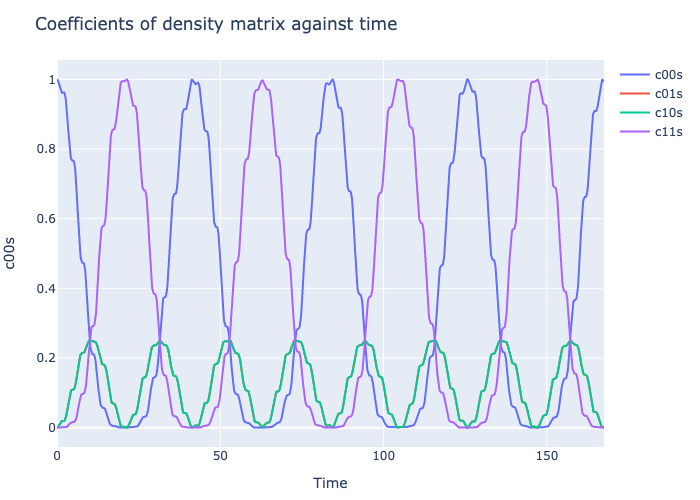

In [9]:
# plot the c00s against time
plot_c00s = scatter(x=ts, y=abs2.(cs[1]), mode="lines", name="c00s")
plot_c01s = scatter(x=ts, y=abs2.(cs[2]), mode="lines", name="c01s")
plot_c10s = scatter(x=ts, y=abs2.(cs[3]), mode="lines", name="c10s")
plot_c11s = scatter(x=ts, y=abs2.(cs[4]), mode="lines", name="c11s")

layout = Layout(
    xaxis_title="Time",
    yaxis_title="c00s",
    title="Coefficients of density matrix against time",
    width=1000,
    height=500
)

plot([plot_c00s, plot_c01s, plot_c10s, plot_c11s], layout)

# Apply the RWA "manually"

Now do this in the RWA, using as our RWA Liouvillian the one found by ignoring all rotating terms in the equations of motion. We also do this at resonance, just to test it out in ideal conditions so to speak. 

It is important that `N=2` in order to compare to the `mesolve` solution.

Moreover, the simulation is done using `OrdinaryDiffEq`, just looking at the evolution of coefficients.

In [420]:
L_rwa = Complex{Float64}[0.0 -εd/2 -εd/2 κ;
    εd/2 -κ/2 0 -εd/2;
    εd/2 0 -κ/2 -εd/2;
    0 εd/2 εd/2 -κ]

ρ0_rwa = Complex{Float64}[1.0, 0.0, 0.0, 0.0];

In [421]:
function f_rwa(dρ, ρ, p, t)
    mul!(dρ, L_rwa, ρ, 1.0, false)  
end;

In [422]:
tspan_rwa = (0.0, 8π / εd)

prob_rwa = ODEProblem(f_rwa, ρ0_rwa, tspan_rwa);

In [423]:
sol_rwa = solve(prob_rwa, Tsit5(), reltol=1e-8, abstol=1e-8);

In [424]:
c00s_rwa = getindex.(sol_rwa.u, 1);
c10s_rwa = getindex.(sol_rwa.u, 2);
c01s_rwa = getindex.(sol_rwa.u, 3);
c11s_rwa = getindex.(sol_rwa.u, 4);

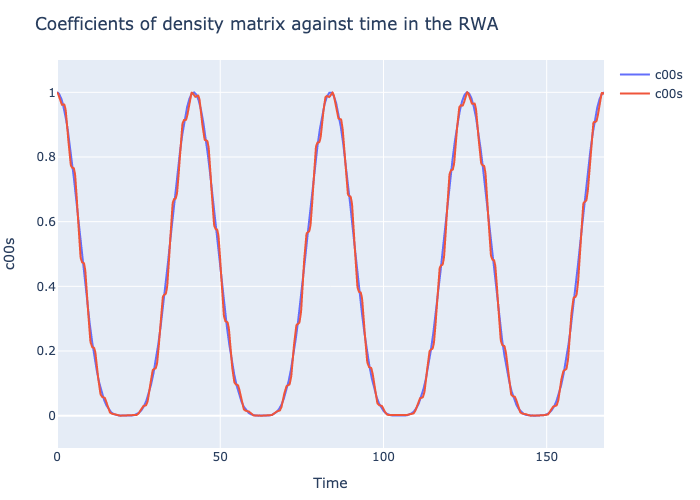

In [425]:
# plot the c00s against time
ts_rwa = sol_rwa.t
plot_c00s_rwa = scatter(x=ts_rwa, y=abs2.(c00s_rwa), mode="lines", name="c00s")
plot_c01s_rwa = scatter(x=ts_rwa, y=abs2.(c01s_rwa), mode="lines", name="c01s")
plot_c10s_rwa = scatter(x=ts_rwa, y=abs2.(c10s_rwa), mode="lines", name="c10s")
plot_c11s_rwa = scatter(x=ts_rwa, y=abs2.(c11s_rwa), mode="lines", name="c11s")

layout = Layout(
    xaxis_title="Time",
    yaxis_title="c00s",
    title="Coefficients of density matrix against time in the RWA",
    width=1000,
    height=500,
    yaxis_range=[-0.1, 1.1]
)

plot([plot_c00s_rwa, plot_c00s], layout)

It matches, as we expect. We have applied the RWA in the Liouvillian picture to our simple effective model. If we add levels, it will not match because this is a linear model. We must add levels non-linearly, so that the driving frequency can still target a single energy transition.

There are many additions we should now consider:
- non-linear $H$
- off-resonant ($\omega_q \neq \omega_d$)
- not-diagonal
- more levels

# Add non-linearity to full model

In [10]:
const K = 0.01

Hq_nonlinear = Hq - K * (b' + b)^4;

# diagonalize the Hamiltonian
evals, evecs = eigen(sparse_to_dense(Hq_nonlinear.data));
U = Qobj(dense_to_sparse(evecs'));

# diagonal Hamiltonian
Hq_nonlinear_diag = U * Hq_nonlinear * U';

# modify drive_operator and dissipation
drive_operator_nonlinear = U * drive_operator * U';
c_ops_nonlinear = [U * c * U' for c in c_ops];

In [13]:
# solve the master equation using mesolve
op_nonlinear = (Hq_nonlinear_diag, (drive_operator_nonlinear, drive_coefficient));
sol_nonlinear = mesolve(op_nonlinear, ρ0, tspan, c_ops, params=(εd=εd, ωd=ωd), saveat=tspan);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


In [14]:
c00s_nl = getindex.(sol_nonlinear.states, 1, 1);
c01s_nl = getindex.(sol_nonlinear.states, 1, 2);
c10s_nl = getindex.(sol_nonlinear.states, 2, 1);
c11s_nl = getindex.(sol_nonlinear.states, 2, 2);

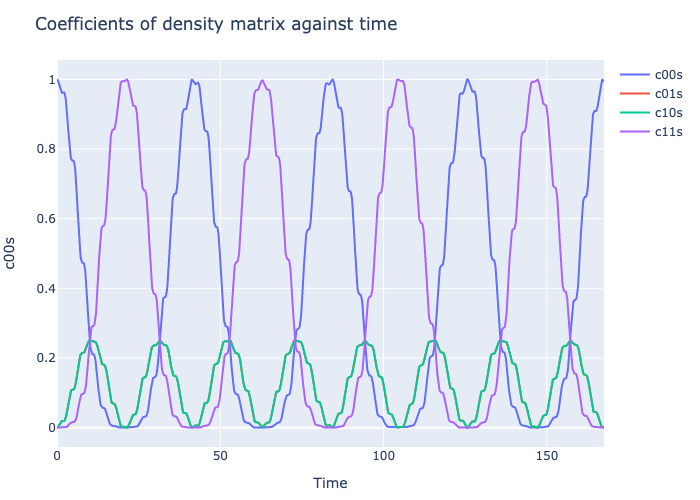

In [15]:
# plot the c00s against time
plot_c00s_nl = scatter(x=tspan, y=abs2.(c00s_nl), mode="lines", name="c00s")
plot_c01s_nl = scatter(x=tspan, y=abs2.(c01s_nl), mode="lines", name="c01s")
plot_c10s_nl = scatter(x=tspan, y=abs2.(c10s_nl), mode="lines", name="c10s")
plot_c11s_nl = scatter(x=tspan, y=abs2.(c11s_nl), mode="lines", name="c11s")

layout = Layout(
    xaxis_title="Time",
    yaxis_title="c00s",
    title="Coefficients of density matrix against time",
    width=1000,
    height=500
)

plot([plot_c00s_nl, plot_c01s_nl, plot_c10s_nl, plot_c11s_nl], layout)

Even adding a small Kerr nonlinearity makes a big difference, as we can verify by comparing the same coefficients for $K=0$ and $K>0$.

# Simulate equations of motion in Liouvillian formalism

Let's make our own function that evolves the density matrix, and use it to compare the coefficients of a non-linear Hamiltonian, small detuning, etc etc. We begin just by making a two-level system, and we will add levels.

In [16]:
function ind2tup(index, n)
    row = div(index - 1, n) + 1
    col = mod(index - 1, n) + 1
    return (Int(row), Int(col))
end

function tup2ind(tuple, n)
    i, j = tuple
    return Int((i - 1) * n + j)
end

function cut_phase(ω, t, ω_max)
    if abs(ω) <= ω_max
        return exp(im * ω * t)
    else
        return 0
    end
end

function f(du, u, p, t)
    # returns the time derivative of the coefficients
    # to be used in ODEProblem
    Es, O, εd, ωd, a, κ, ω_max = p.Es, p.O, p.εd, p.ωd, p.a, p.κ, p.ω_max
    N = length(Es)
    L = Int(N^2)
    for n in 1:L
        i,j = ind2tup(n, N)
        du[n] = 0.
        for k in 1:N
            # Hamiltonian part
            Eik = Es[i] - Es[k]
            Ekj = Es[k] - Es[j]
            Oik = O[i,k]
            ckj = u[tup2ind((k,j), N)]
            Okj = O[k,j]
            cik = u[tup2ind((i,k), N)]
            # do the cutoff approximation
            du[n] += -εd/2 * (Oik * ckj * cut_phase(Eik + ωd, t, ω_max) - cik * Okj * cut_phase(Ekj + ωd, t, ω_max))
            du[n] -= -εd/2 * (Oik * ckj * cut_phase(Eik - ωd, t, ω_max) - cik * Okj * cut_phase(Ekj - ωd, t, ω_max))

            # dissipation
            for l in 1:N
                aik = a[i,k]
                ckl = u[tup2ind((k,l), N)]
                adlj = a[j,l]'

                adik = a[k,i]'
                akl = a[k,l]
                clj = u[tup2ind((l,j), N)]

                cik = u[tup2ind((i,k), N)]
                adkl = a[l,k]'
                alj = a[l,j]

                Elj = Es[l] - Es[j]
                Ekl = Es[k] - Es[l]

                du[n] += κ * (aik * ckl * adlj * cut_phase(Eik + Elj, t, ω_max))
                du[n] -= κ/2 * (adik * akl * clj * cut_phase(Eik + Ekl, t, ω_max))
                du[n] -= κ/2 * (cik * adkl * alj * cut_phase(Ekl + Elj, t, ω_max))
            end
        end
    end
    return du
end;

function make_f(ω_max)
    # return the function `f` for a given ω_max cutoff
    # make a one-line function that already assumes ω_max
    f_cut(du, u, p, t) = begin
        du = f(du, u, (Es=p.Es, O=p.O, εd=p.εd, ωd=p.ωd, a=p.a, κ=p.κ, ω_max=ω_max), t)
    end
end

# function coefficients_evolve(u0, Es, O, εd, ωd, tspan)
#     # homegrown function that does not preserve the norm :)
#     # to be deleted later -- just for play-testing 
#     dt = tspan[2] - tspan[1]
#     u = u0
#     du = zeros(Complex{Float64}, 4)
#     us = zeros(Complex{Float64}, 4, length(tspan))
#     for (i, t) in enumerate(tspan)
#         du = coefficients_evolve_step(du, u, Es, O, εd, ωd, t)
#         u += du .* dt
#         us[:,i] = u / (u[1] + u[4])
#     end
#     return us
# end;

function get_frequencies(H0, ωd)
    # return all the frequencies of the problem in increasing magnitude
    Es = diag(H0)
    diff_Es = Es .- Es' |> unique
    frequencies = abs.(vcat(diff_Es .+ ωd, diff_Es .- ωd)) |> unique! |> x -> sort(x)
end

get_frequencies (generic function with 1 method)

In [17]:
N = 3
O = ComplexF64[0. 1 0;1 0 1; 0. 1 0]
Es = Float64[0.0, 1.0, 3.0]
εd=0.15
ωd=1.
a = ComplexF64[0. 1 0;0 0 1; 0. 0 0]
κ = 0.0

u0=zeros(Complex{Float64}, 9)
u0[1] = 1.0

tspan = (0.0, 8π / εd)

test = make_f(10.)

prob = ODEProblem(test, u0, tspan, (Es=Es, O=O, εd=εd, ωd=ωd, a=a, κ=κ))
@benchmark sol = solve(prob, Tsit5())

BenchmarkTools.Trial: 597 samples with 1 evaluation.
 Range (min … max):  8.182 ms … 59.468 ms  ┊ GC (min … max): 0.00% … 85.97%
 Time  (median):     8.266 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.368 ms ±  2.100 ms  ┊ GC (mean ± σ):  1.07% ±  3.64%

     ▁▃▅█▆▄▇▄▁▆▂                                              
  ▄▇████████████▇▇▅▄▅▄▃▃▂▃▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂ ▃
  8.18 ms        Histogram: frequency by time        8.73 ms <

 Memory estimate: 584.47 KiB, allocs estimate: 2950.

In [18]:
prob = ODEProblem(f, u0, tspan, (Es=Es, O=O, εd=εd, ωd=ωd, a=a, κ=κ, ω_max=10.))
@benchmark sol = solve(prob, Tsit5())

BenchmarkTools.Trial: 602 samples with 1 evaluation.
 Range (min … max):  8.147 ms … 60.629 ms  ┊ GC (min … max): 0.00% … 86.39%
 Time  (median):     8.212 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.306 ms ±  2.136 ms  ┊ GC (mean ± σ):  1.06% ±  3.53%

           ▁▂▅▁▄▄█▅▂▂       ▁                                 
  ▂▁▃▄▄▅▇▇▇██████████▇▇██▇▇▇█▅▅▄▄▄▄▃▃▃▃▃▃▁▃▁▂▂▁▁▁▁▁▂▁▁▃▁▂▁▁▂ ▄
  8.15 ms        Histogram: frequency by time        8.38 ms <

 Memory estimate: 584.42 KiB, allocs estimate: 2946.

## $\kappa = 0$, diagonal $H_0$.

We can vary the cutoff frequency $\omega_{\mathrm{max}}$, the number of levels, and the detuning.

### Two-level & three-level system

In [19]:
N = 3
O = ComplexF64[0. 1 0;1 0 1; 0. 1 0]
Es = Float64[0.0, 1.0, 3.0]
εd=0.15
ωd=1.
a = ComplexF64[0. 1 0;0 0 1; 0. 0 0]
κ = 0.0
ω_max=10.

u0=zeros(Complex{Float64}, 9)
u0[1] = 1.0

tspan = (0.0, 8π / εd)

prob = ODEProblem(f, u0, tspan, (Es=Es, O=O, εd=εd, ωd=ωd, a=a, κ=κ, ω_max=ω_max))
sol = solve(prob, Tsit5());

In [20]:
c00s = getindex.(sol.u, 1);

In [21]:
# compare with mesolve
ts, cs = get_coefficient_mesolve(N, [(1,1)], ket2dm(basis(N,0)), 0:0.1:8π/εd, Qobj(diagm(Es)), Qobj(O), ωd, εd, Qobj(O)*0, 0);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


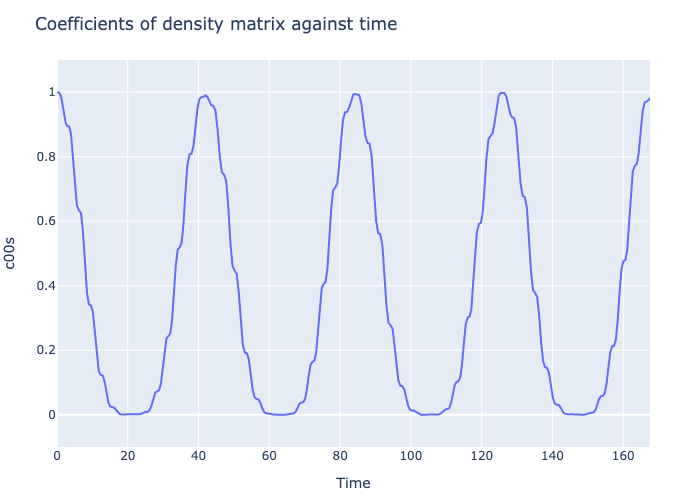

In [22]:
plot_c00s_full = scatter(x=sol.t, y=abs2.(c00s), mode="lines", name="c00s")
plot_c00s_mesolve = scatter(x=ts, y=abs2.(cs[1]), mode="lines", name="c00s")

layout = Layout(
    xaxis_title="Time",
    yaxis_title="c00s",
    title="Coefficients of density matrix against time",
    width=1000,
    height=500,
    yaxis_range=[-0.1, 1.1]
)

plot([plot_c00s_full], layout)

The coefficients may not match exactly because they are in the interaction picture. This is a question for Alberto: doing unitary transformations for `mesolve`.

In [23]:
num_op = Qobj(diagm(0.:N-1))

ρs = [Qobj(vec2mat(sol.u[i])) for i in 1:length(sol.u)];

ns_full = expect(num(N), ρs);

# using mesolve
op = (Qobj(diagm(Es)), (Qobj(O), (p, t) -> p.εd * cos(p.ωd * t)));
res = mesolve(op, ket2dm(basis(N,0)), 0:0.1:8π/εd, [], e_ops=[num(N)], params=(εd=εd, ωd=ωd));

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


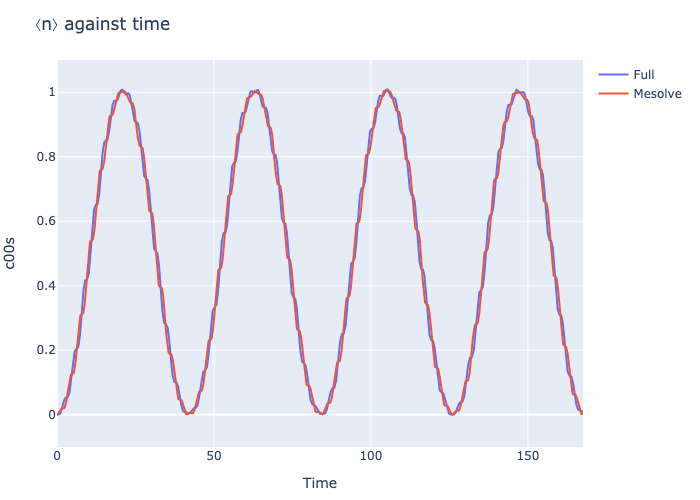

In [24]:
plot_ns_full = scatter(x=sol.t, y=real.(ns_full), mode="lines", name="Full")
plot_ns_mesolve = scatter(x=0:0.1:8π/εd, y=real.(res.expect[:]), mode="lines", name="Mesolve")

layout = Layout(
    xaxis_title="Time",
    yaxis_title="c00s",
    title="⟨n⟩ against time",
    width=1000,
    height=500,
    yaxis_range=[-0.1, 1.1]
)

plot([plot_ns_full, plot_ns_mesolve], layout)

The expectation values are different, which is troubling. 

### Add dissipation

In [ ]:
N = 3
O = ComplexF64[0. 1 0;1 0 1; 0. 1 0]
Es = Float64[0.0, 1.0, 3.0]
εd=0.15
ωd=0.8
a = ComplexF64[0. 1 0;0 0 1; 0. 0 0]
κ = 0.01
ω_max=get_frequencies(Qobj(diagm(Es)), ωd)[2] # here is where we choose the max frequency cutoff
println("Maximum frequency: ", ω_max)

u0=zeros(Complex{Float64}, 9)
u0[1] = 1.0

tspan = (0.0, 8π / εd)

prob = ODEProblem(f, u0, tspan, (Es=Es, O=O, εd=εd, ωd=ωd, a=a, κ=κ, ω_max=ω_max))
sol = solve(prob, Tsit5());

Maximum frequency: 0.8


In [29]:
c00s = getindex.(sol.u, 1);
ts, cs = get_coefficient_mesolve(N, [(1,1)], ket2dm(basis(N,0)), 0:0.1:8π/εd, Qobj(diagm(Es)), Qobj(O), ωd, εd, Qobj(a), κ);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


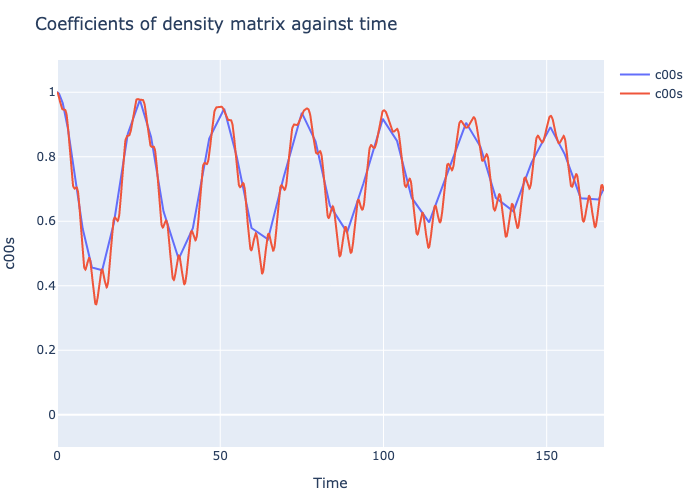

In [30]:
plot_c00s_full = scatter(x=sol.t, y=abs2.(c00s), mode="lines", name="c00s")
plot_c00s_mesolve = scatter(x=ts, y=abs2.(cs[1]), mode="lines", name="c00s")

layout = Layout(
    xaxis_title="Time",
    yaxis_title="c00s",
    title="Coefficients of density matrix against time",
    width=1000,
    height=500,
    yaxis_range=[-0.1, 1.1]
)

plot([plot_c00s_full, plot_c00s_mesolve], layout)

Now check the expectation values

In [31]:
ρs = [Qobj(vec2mat(sol.u[i])) for i in 1:length(sol.u)];

ns_full = expect(num(N), ρs);

# using mesolve
op = (Qobj(diagm(Es)), (Qobj(O), (p, t) -> p.εd * cos(p.ωd * t)));
res = mesolve(op, ket2dm(basis(N,0)), 0:0.1:8π/εd, [√κ * Qobj(a)], e_ops=[num(N)], params=(εd=εd, ωd=ωd));

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


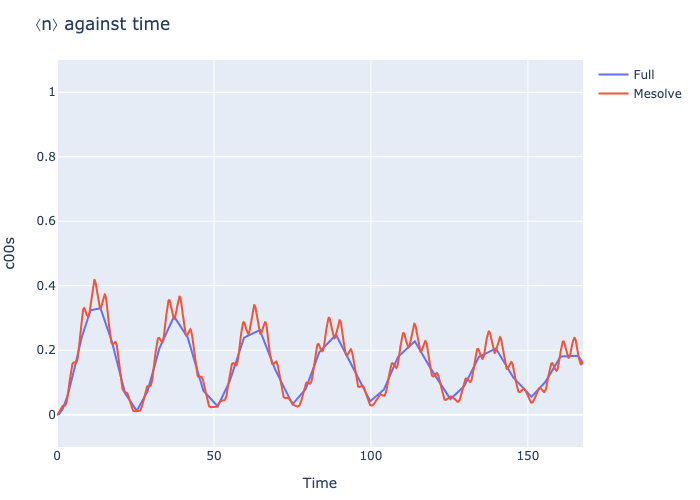

In [32]:
plot_ns_full = scatter(x=sol.t, y=real.(ns_full), mode="lines", name="Full")
plot_ns_mesolve = scatter(x=0:0.1:8π/εd, y=real.(res.expect[:]), mode="lines", name="Mesolve")

layout = Layout(
    xaxis_title="Time",
    yaxis_title="c00s",
    title="⟨n⟩ against time",
    width=1000,
    height=500,
    yaxis_range=[-0.1, 1.1]
)

plot([plot_ns_full, plot_ns_mesolve], layout)